In [29]:
!pip install tensorflow~=2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
import zipfile
import os

from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Conv1D, Conv1DTranspose
from keras.layers import LSTM, LeakyReLU, ELU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

In [31]:
! chmod 600 /content/kaggle.json

In [32]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d sudalairajkumar/cryptocurrencypricehistory

cryptocurrencypricehistory.zip: Skipping, found more recently modified local copy (use --force to force download)


In [33]:
local_zip = '/content/cryptocurrencypricehistory.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [34]:
# Load the data
data = pd.read_csv('coin_Bitcoin.csv')
print(data.shape)

(2991, 10)


In [35]:
data

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


In [36]:
# Preprocess the data
data = data.dropna()
data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data = data.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
data = data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, 
                    axis=1)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()

In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [38]:
data

array([[0.00103914, 0.00119979, 0.00112561, 0.00110187],
       [0.00118974, 0.00111246, 0.001117  , 0.00110267],
       [0.00111094, 0.00076549, 0.00100834, 0.00067898],
       ...,
       [0.54521982, 0.5552035 , 0.55353936, 0.55244693],
       [0.55497125, 0.53089867, 0.54345698, 0.53341328],
       [0.53037384, 0.53861036, 0.53966298, 0.53962882]])

In [39]:
# Define the generator model
def make_generator_model():
    model = Sequential([
        Dense(256, input_shape=(100,), kernel_initializer=RandomNormal(stddev=0.02)),
        BatchNormalization(),
        Dense(512),
        BatchNormalization(),
        Dense(1024),
        BatchNormalization(),
        Dense(2048),
        BatchNormalization(),
        Dense(4096),
        BatchNormalization(),
        Dense(2048),
        BatchNormalization(),
        Dense(1024),
        BatchNormalization(),
        Dense(512),
        BatchNormalization(),
        Dense(256),
        BatchNormalization(),
        Dense(24*7*4*4, activation='tanh'),
        Reshape((24*7*4, 4))
    ])
    return model

# Define the discriminator model
def make_discriminator_model():
    model = Sequential([
        Conv1D(64, 3, strides=2, padding='same', input_shape=(24*7*4, 4)),
        Dropout(0.5),
        Conv1D(128, 3, strides=2, padding='same'),
        Dropout(0.5),
        Conv1D(256, 3, strides=2, padding='same'),
        Dropout(0.5),
        Conv1D(512, 3, strides=2, padding='same'),
        Dropout(0.5),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

# Combine the generator and discriminator models to form a GAN
def make_gan_model(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    model = Model(gan_input, gan_output)
    return model

In [40]:
# Set hyperparameters
epochs = 1001
batch_size = 128

# Create the generator, discriminator, and GAN models
generator = make_generator_model()
discriminator = make_discriminator_model()
gan = make_gan_model(generator, discriminator)

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Compile the GAN
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [41]:
# Assuming data is a numpy array of shape (num_samples, 4)
new_data = data[:, [0, 3]]
num_samples = data.shape[0]
time_steps = 672
features = 4

# Create a new numpy array of shape (num_samples - time_steps + 1, time_steps, features)
new_data = np.zeros((num_samples - time_steps + 1, time_steps, features))

# Fill the new numpy array with rolling windows of size time_steps
for i in range(num_samples - time_steps + 1):
    new_data[i] = data[i:i+time_steps, :]

In [42]:
# create output data for generated data
if not os.path.exists('/content/output'):
  os.makedirs('/content/output')

# Train the GAN
for epoch in range(epochs):
    # Train the discriminator
    idx = np.random.randint(0, new_data.shape[0], batch_size)
    real_data = new_data[idx]
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_data = generator.predict(noise)
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
    # Print progress
    print(f'Epoch {epoch+1}/{epochs} - D loss: {d_loss} - G loss: {g_loss}')
    # Save generated samples every 100 epochs
    if (epoch+1) % 200 == 0:
        noise = np.random.normal(0, 1, (1, 100))
        generated_data = generator.predict(noise)
        generated_data = generated_data.reshape((24*7*4, 4))
        generated_data = scaler.inverse_transform(generated_data)
        generated_data = pd.DataFrame(generated_data, columns=['open', 'close', 'high', 'low'])
        generated_data.to_csv(f'/content/output/generated_data_epoch{epoch+1}.csv', index=False)

4/4 [==============================] - 1s 4ms/step
Epoch 1/1001 - D loss: 0.6878347396850586 - G loss: 0.7028002738952637
4/4 [==============================] - 0s 4ms/step
Epoch 2/1001 - D loss: 0.6987103223800659 - G loss: 0.6985917687416077
4/4 [==============================] - 0s 3ms/step
Epoch 3/1001 - D loss: 0.7007648050785065 - G loss: 0.7188718318939209
4/4 [==============================] - 0s 3ms/step
Epoch 4/1001 - D loss: 0.7024950981140137 - G loss: 0.6860327124595642
4/4 [==============================] - 0s 3ms/step
Epoch 5/1001 - D loss: 0.695338785648346 - G loss: 0.6916372179985046
4/4 [==============================] - 0s 3ms/step
Epoch 6/1001 - D loss: 0.6871645152568817 - G loss: 0.6756123304367065
4/4 [==============================] - 0s 3ms/step
Epoch 7/1001 - D loss: 0.6959256231784821 - G loss: 0.708937406539917
4/4 [==============================] - 0s 3ms/step
Epoch 8/1001 - D loss: 0.7045038342475891 - G loss: 0.712082028388977
4/4 [======================

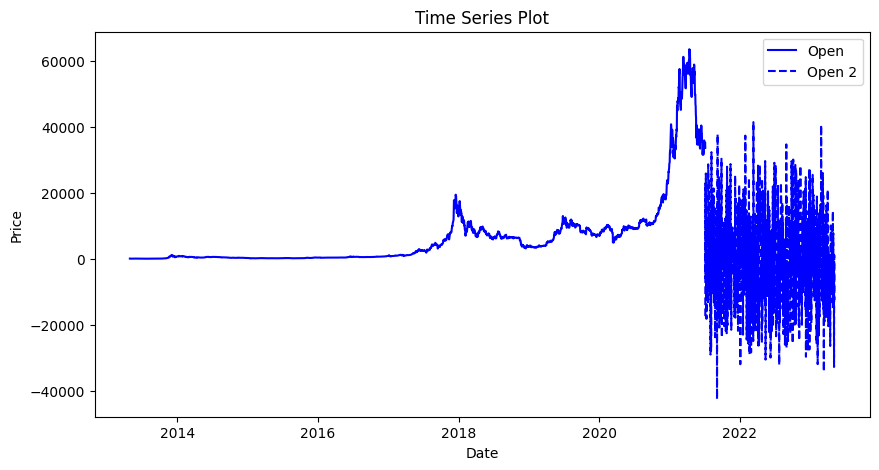

In [43]:
import matplotlib.pyplot as plt
reversed_data = scaler.inverse_transform(data) 
df = pd.DataFrame(reversed_data, columns=['open', 'close', 'high', 'low'])
df.index = pd.date_range(start='2013-04-29', periods=len(df), freq='D')

df_generated = pd.read_csv('/content/output/generated_data_epoch200.csv')
df_generated.index = pd.date_range(start='2021-07-06', periods=len(df_generated), freq='D')

# # Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df.index, df['open'], label='Open', color='blue')
# ax.plot(df.index, df['close'], label='Close', color='orange')
# ax.plot(df.index, df['high'], label='High', color='green')
# ax.plot(df.index, df['low'], label='Low', color='red')

ax.plot(df_generated.index, df_generated['open'], label='Open 2', linestyle='--', color='blue')
# ax.plot(df_generated.index, df_generated['close'], label='Close 2', linestyle='--', color='orange')
# ax.plot(df_generated.index, df_generated['high'], label='High 2', linestyle='--', color='green')
# ax.plot(df_generated.index, df_generated['low'], label='Low 2', linestyle='--', color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Time Series Plot')
ax.legend()
plt.show()